In [1]:
import pandas as pd
import math
import numpy as np
from scipy import stats

# ファイルを読み込む
pd_reader = pd.read_csv("金融工学_第11回_スマートベータデータ.csv", encoding="ANSI")
df = pd_reader
display(df)

C:\Users\apple\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


,yyyymm,等ウェイト,高配当,最小分散,クオリティ,企業価値,市場指数
0,200001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,200002,-4.326403,-7.506763,-2.580708,5.451383,-3.507194,-0.025701
2,200003,6.431353,5.873751,3.001612,-2.968766,5.069897,1.072972
3,200004,-0.590110,3.522099,0.107569,-1.200467,-0.816037,-2.541618
4,200005,1.626499,2.168112,-3.809710,-10.021505,-2.298337,-5.430798
...,...,...,...,...,...,...,...
247,202008,9.403594,10.961215,6.892987,3.240581,10.404669,7.936409
248,202009,0.771339,-1.601116,-0.309241,3.860360,-1.731106,0.618640
249,202010,-3.804058,-0.241031,-3.954824,-1.749322,-2.690068,-2.519181
250,202011,11.116687,8.799679,8.668490,13.346730,10.694101,12.212388


In [2]:
import pandas as pd
columns = ['等ウェイト','高配当','最小分散','クオリティ','企業価値']
df_new = pd.DataFrame()
for column in columns:
    tmp = df[column]
    tmp = df[column] - df['市場指数']
    df_new[column] = tmp

df_new['yyyymm'] = df['yyyymm']
display(df_new[0:5])

,等ウェイト,高配当,最小分散,クオリティ,企業価値,yyyymm
0,0.000000,0.000000,0.000000,0.000000,0.000000,200001
1,-4.300702,-7.481062,-2.555008,5.477084,-3.481494,200002
2,5.358381,4.800779,1.928640,-4.041738,3.996926,200003
3,1.951509,6.063718,2.649187,1.341151,1.725582,200004
4,7.057297,7.598910,1.621088,-4.590708,3.132461,200005


In [3]:
import pandas as pd
import math
import numpy as np
from scipy import stats

# ファイルを読み込む
pd_reader = pd.read_csv("data_10.csv", encoding="ANSI")
df = pd_reader
factors = ['PER','PBR',
           '配当利回り','reversal','売買回転率',
           'ボラティリティ','自己資本比率','ROE',
           '売上高成長率','売上高営業利益率','accrual比率']
# 時間推移関数
def nextym(yyyymm):
    yyyymm = yyyymm + 1
    if yyyymm % 100 == 13:
        yyyymm = yyyymm + 88
    return yyyymm
# Ｔ検定関数
def student(mean, var_x, var_y, n_x, n_y):
    T = mean / math.sqrt(var_x/n_x + var_y/n_y)
    return T
#因子効果の計測
def calculate_metrics(df, column_name):
    yyyymm = 200501  # 起始日期
    end_date = 202012  # 终止日期

    SPD = []  # 存储 SPD 指标
    TOP = []  # 存储 top_rtn0 指标
    BOT = []  # 存储 bot_rtn0 指标
    top_rtn = []  # 存储 top_rtn 累积值
    bot_rtn = []  # 存储 bot_rtn 累积值

    top_sum = 0.0  # top_rtn 累积值的初始值
    bot_sum = 0.0  # bot_rtn 累积值的初始值
    n = 0
    
    while yyyymm <= end_date:
        
        tmp = df[df['yyyymm'] == yyyymm]
        tmp = tmp.copy()
        for factor in factors:
            tmp[factor].fillna(tmp[factor].mean(), inplace=True)
        
        # 计算 top_rtn0
        top = tmp.loc[:, column_name].quantile(q=0.9)
        tmp_2 = tmp[tmp[column_name] >= top]
        top_rtn0 = tmp_2.loc[:, '翌1M収益率'].mean()

        # 计算 bot_rtn0
        bot = tmp.loc[:, column_name].quantile(q=0.1)
        tmp_2 = tmp[tmp[column_name] <= bot]
        bot_rtn0 = tmp_2.loc[:, '翌1M収益率'].mean()

        # 计算 SPD
        spd0 = bot_rtn0 - top_rtn0
        SPD.append(spd0)

        # 存储 top_rtn0
        TOP.append(top_rtn0)
        top_sum += top_rtn0
        top_rtn.append(top_sum)

        # 存储 bot_rtn0
        BOT.append(bot_rtn0)
        bot_sum += bot_rtn0
        bot_rtn.append(bot_sum)
        
        spd_rtn = np.array(bot_rtn) - np.array(top_rtn)
    
        n = n + 1
        
        yyyymm = nextym(yyyymm)  # 更新日期
        
    t = student(pd.Series(SPD).mean(), pd.Series(TOP).var(), pd.Series(BOT).var(), 192, 192)  
    
    return top_rtn,bot_rtn,t,pd.Series(SPD).mean(),pd.Series(SPD).std(),SPD

df_factor = pd.DataFrame()
for factor in factors:
    cap_top_acc, cap_bot_acc, cap_SPD, cap_mean, cap_std, SPD = calculate_metrics(df, factor)
    df_factor[factor] = pd.DataFrame(SPD)
display(df_factor[0:5])

,PER,PBR,配当利回り,reversal,売買回転率,ボラティリティ,自己資本比率,ROE,売上高成長率,売上高営業利益率,accrual比率
0,-1.273210,-3.092440,2.257697,1.879909,-1.597993,0.469732,-2.017620,4.087450,2.368141,5.336859,-0.456469
1,-2.347430,1.287724,0.860942,-0.364368,3.365446,4.547703,4.115327,0.303534,1.040281,0.691150,-2.607510
2,1.479657,2.905451,-2.241350,0.474103,2.104456,-0.366996,-2.137348,-2.139055,-0.881974,-0.242399,1.495326
3,-0.043969,0.961006,-0.135139,0.051725,3.168489,3.903923,0.417422,-0.184133,0.241922,-1.189338,2.881277
4,1.456138,0.634356,0.733014,-1.172868,-2.541889,-3.478766,-2.444319,1.953307,-0.091140,1.723560,1.014016


In [4]:
ym = []
yyyymm = 200412  # 起始日期
end_date = 202011  # 终止日期
while yyyymm <= end_date:
    
    ym.append(yyyymm)
    yyyymm = nextym(yyyymm)
print(ym)
df_factor['yyyymm'] = ym

[200412, 200501, 200502, 200503, 200504, 200505, 200506, 200507, 200508, 200509, 200510, 200511, 200512, 200601, 200602, 200603, 200604, 200605, 200606, 200607, 200608, 200609, 200610, 200611, 200612, 200701, 200702, 200703, 200704, 200705, 200706, 200707, 200708, 200709, 200710, 200711, 200712, 200801, 200802, 200803, 200804, 200805, 200806, 200807, 200808, 200809, 200810, 200811, 200812, 200901, 200902, 200903, 200904, 200905, 200906, 200907, 200908, 200909, 200910, 200911, 200912, 201001, 201002, 201003, 201004, 201005, 201006, 201007, 201008, 201009, 201010, 201011, 201012, 201101, 201102, 201103, 201104, 201105, 201106, 201107, 201108, 201109, 201110, 201111, 201112, 201201, 201202, 201203, 201204, 201205, 201206, 201207, 201208, 201209, 201210, 201211, 201212, 201301, 201302, 201303, 201304, 201305, 201306, 201307, 201308, 201309, 201310, 201311, 201312, 201401, 201402, 201403, 201404, 201405, 201406, 201407, 201408, 201409, 201410, 201411, 201412, 201501, 201502, 201503, 201504,

In [5]:
df_ = pd.merge(df_factor,df_new,on = 'yyyymm')
df1 = df_.drop('yyyymm', 1)
display(df1[0:5])

C:\Users\apple\AppData\Local\Temp\ipykernel_21448\790920555.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df1 = df_.drop('yyyymm', 1)


,PER,PBR,配当利回り,reversal,売買回転率,ボラティリティ,自己資本比率,ROE,売上高成長率,売上高営業利益率,accrual比率,等ウェイト,高配当,最小分散,クオリティ,企業価値
0,-1.273210,-3.092440,2.257697,1.879909,-1.597993,0.469732,-2.017620,4.087450,2.368141,5.336859,-0.456469,-0.380465,-1.876583,-0.502414,-0.010748,-0.615754
1,-2.347430,1.287724,0.860942,-0.364368,3.365446,4.547703,4.115327,0.303534,1.040281,0.691150,-2.607510,2.269173,1.344987,0.864938,-0.561988,0.430701
2,1.479657,2.905451,-2.241350,0.474103,2.104456,-0.366996,-2.137348,-2.139055,-0.881974,-0.242399,1.495326,-0.129637,0.479075,-0.199081,-1.413234,1.068689
3,-0.043969,0.961006,-0.135139,0.051725,3.168489,3.903923,0.417422,-0.184133,0.241922,-1.189338,2.881277,0.532837,0.793124,1.090576,-1.098732,0.119048
4,1.456138,0.634356,0.733014,-1.172868,-2.541889,-3.478766,-2.444319,1.953307,-0.091140,1.723560,1.014016,0.212790,1.559356,0.909592,0.563709,0.285699


,PER,PBR,配当利回り,reversal,売買回転率,ボラティリティ,自己資本比率,ROE,売上高成長率,売上高営業利益率,accrual比率,等ウェイト,高配当,最小分散,クオリティ,企業価値
PER,0.0,35.0,43.5,83.6,85.8,94.3,43.5,40.2,44.1,39.9,34.3,29.9,39.0,42.4,39.0,30.4
PBR,35.0,0.0,59.2,86.2,69.3,79.9,49.9,48.9,42.9,52.9,38.1,34.4,38.4,44.2,42.2,34.3
配当利回り,43.5,59.2,0.0,75.2,87.2,96.1,44.2,33.7,40.5,34.2,41.2,37.6,44.6,47.1,45.8,36.9
reversal,83.6,86.2,75.2,0.0,83.4,87.0,89.3,81.9,80.4,83.6,69.5,72.4,75.4,78.0,77.5,70.0
売買回転率,85.8,69.3,87.2,83.4,0.0,32.6,88.9,79.2,69.6,85.1,69.6,69.7,73.2,73.6,74.4,69.3
ボラティリティ,94.3,79.9,96.1,87.0,32.6,0.0,94.4,89.6,78.8,94.5,77.0,77.7,80.0,79.7,80.6,76.8
自己資本比率,43.5,49.9,44.2,89.3,88.9,94.4,0.0,48.2,42.8,50.3,47.9,38.3,41.9,46.3,43.2,38.9
ROE,40.2,48.9,33.7,81.9,79.2,89.6,48.2,0.0,29.7,25.1,38.7,37.0,43.3,46.7,47.1,35.6
売上高成長率,44.1,42.9,40.5,80.4,69.6,78.8,42.8,29.7,0.0,34.2,37.0,34.7,38.2,43.3,43.1,32.4
売上高営業利益率,39.9,52.9,34.2,83.6,85.1,94.5,50.3,25.1,34.2,0.0,41.4,39.3,45.7,49.3,48.2,37.3


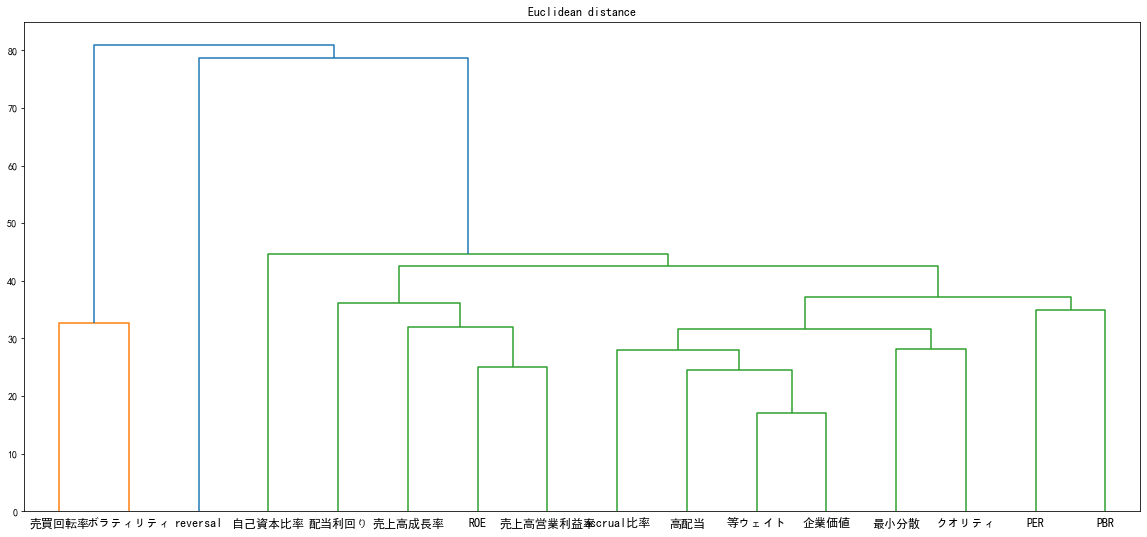

In [31]:
import scipy
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.vq import vq,kmeans,whiten
import numpy as np
import matplotlib.pylab as plt
from matplotlib import rcParams
rcParams['font.family'] = 'SimHei'
plt.rcParams['figure.figsize']=(20, 9.0)
np.set_printoptions(precision=8)

FactorBeta = factors + columns
x = df1.values.T
DisMat = sch.distance.pdist(x,'euclidean')
plt.title("Euclidean distance")
D = squareform(DisMat)
np.set_printoptions(precision=0)

D = pd.DataFrame(D)
D.columns = [FactorBeta]
D.index = [FactorBeta]
display(D.round(1))

Z=sch.linkage(DisMat,method='average') 
P=sch.dendrogram(Z,labels=FactorBeta)
plt.savefig('euclidean.png',facecolor="white",edgecolor="white")

,PER,PBR,配当利回り,reversal,売買回転率,ボラティリティ,自己資本比率,ROE,売上高成長率,売上高営業利益率,accrual比率,等ウェイト,高配当,最小分散,クオリティ,企業価値
PER,0.0,357.2,489.2,796.9,889.3,969.6,473.1,434.1,464.7,433.0,355.6,324.9,402.7,452.3,421.8,323.2
PBR,357.2,0.0,634.6,857.9,688.9,805.1,510.6,502.8,469.1,536.0,408.6,381.9,435.0,479.0,459.0,384.3
配当利回り,489.2,634.6,0.0,730.9,923.5,1005.1,478.8,365.4,428.8,381.5,421.0,393.5,452.6,498.3,488.6,385.3
reversal,796.9,857.9,730.9,0.0,913.4,932.5,868.9,821.1,794.7,798.4,694.7,720.4,737.6,795.7,788.7,682.2
売買回転率,889.3,688.9,923.5,913.4,0.0,352.0,916.7,844.4,731.4,895.1,713.7,723.9,762.2,778.1,782.6,736.0
ボラティリティ,969.6,805.1,1005.1,932.5,352.0,0.0,967.0,909.1,785.8,954.3,789.9,797.8,824.2,840.1,851.9,792.1
自己資本比率,473.1,510.6,478.8,868.9,916.7,967.0,0.0,501.2,439.9,526.1,501.1,409.1,456.0,489.1,465.7,424.2
ROE,434.1,502.8,365.4,821.1,844.4,909.1,501.2,0.0,325.5,263.2,393.3,392.1,448.3,479.9,485.6,379.7
売上高成長率,464.7,469.1,428.8,794.7,731.4,785.8,439.9,325.5,0.0,378.4,394.6,366.9,396.5,460.7,446.9,338.0
売上高営業利益率,433.0,536.0,381.5,798.4,895.1,954.3,526.1,263.2,378.4,0.0,417.9,406.1,457.1,504.6,492.7,387.5


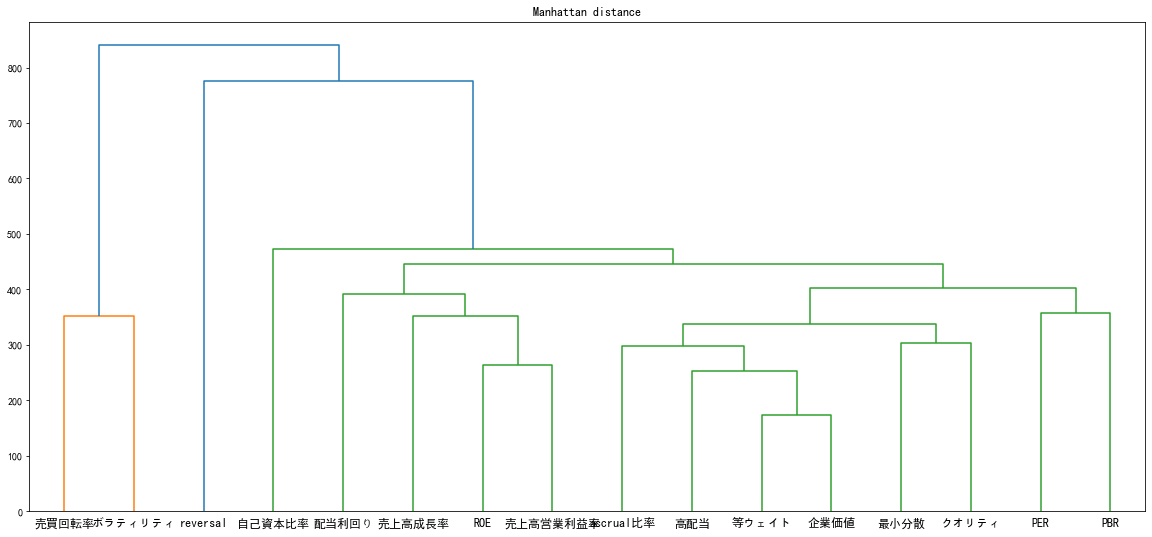

In [33]:
np.set_printoptions(precision=8)

x = df1.values.T
DisMat = sch.distance.pdist(x,'cityblock')
plt.title("Manhattan distance")
D = squareform(DisMat)
np.set_printoptions(precision=0)

D = pd.DataFrame(D)
D.columns = [FactorBeta]
D.index = [FactorBeta]
display(D.round(1))

Z=sch.linkage(DisMat,method='average') 
P=sch.dendrogram(Z,labels=FactorBeta)
plt.savefig('Manhattan distance.png',facecolor="white")

,PER,PBR,配当利回り,reversal,売買回転率,ボラティリティ,自己資本比率,ROE,売上高成長率,売上高営業利益率,accrual比率,等ウェイト,高配当,最小分散,クオリティ,企業価値
PER,0.0,12.6,18.2,25.8,27.0,28.2,18.7,15.6,17.4,15.6,13.0,12.5,15.3,16.9,16.7,12.1
PBR,12.6,0.0,23.1,27.8,22.0,24.5,19.5,18.7,17.2,19.3,15.3,14.7,16.4,17.6,18.1,14.5
配当利回り,18.2,23.1,0.0,23.9,28.4,29.9,17.4,13.9,16.3,14.3,16.1,14.2,16.6,18.1,18.4,14.1
reversal,25.8,27.8,23.9,0.0,30.0,30.3,27.9,26.6,26.3,25.7,22.9,23.2,24.1,27.0,26.1,21.9
売買回転率,27.0,22.0,28.4,30.0,0.0,13.6,27.8,25.9,22.4,27.1,22.9,22.2,23.9,24.9,25.1,22.2
ボラティリティ,28.2,24.5,29.9,30.3,13.6,0.0,28.0,27.3,23.6,28.4,24.6,23.9,25.0,25.9,26.4,23.4
自己資本比率,18.7,19.5,17.4,27.9,27.8,28.0,0.0,18.0,16.0,19.5,18.4,14.7,16.7,17.8,17.4,15.5
ROE,15.6,18.7,13.9,26.6,25.9,27.3,18.0,0.0,12.3,10.6,14.8,13.4,16.1,17.0,17.0,13.5
売上高成長率,17.4,17.2,16.3,26.3,22.4,23.6,16.0,12.3,0.0,14.3,14.8,13.4,15.1,17.1,16.2,13.0
売上高営業利益率,15.6,19.3,14.3,25.7,27.1,28.4,19.5,10.6,14.3,0.0,14.6,13.9,16.6,17.7,17.4,13.7


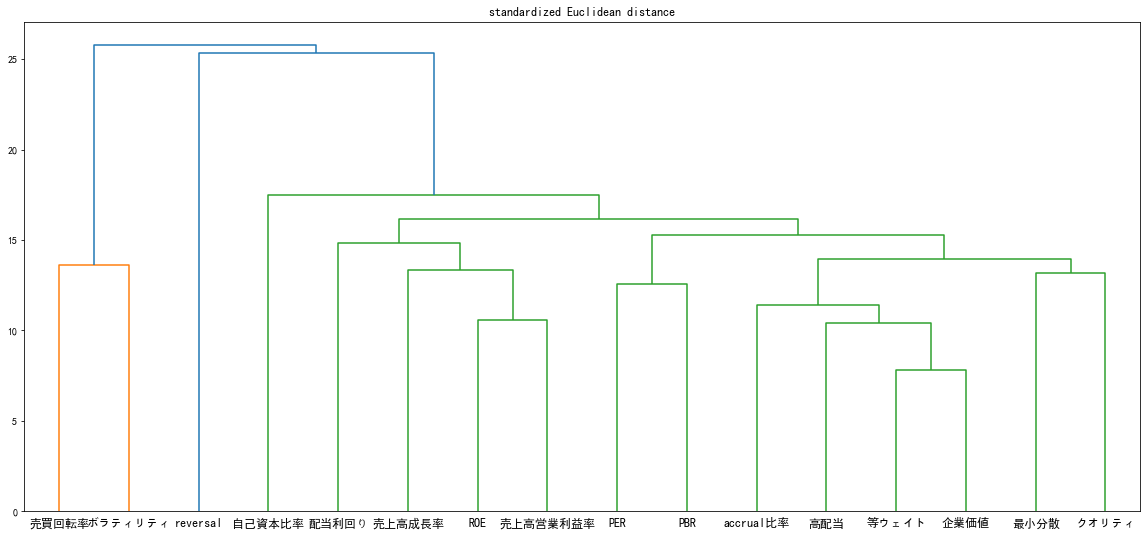

In [35]:
np.set_printoptions(precision=8)

x = df1.values.T
DisMat = sch.distance.pdist(x,'seuclidean')
plt.title("standardized Euclidean distance")
D = squareform(DisMat)
np.set_printoptions(precision=0)

D = pd.DataFrame(D)
D.columns = [FactorBeta]
D.index = [FactorBeta]
display(D.round(1))

Z=sch.linkage(DisMat,method='average') 
P=sch.dendrogram(Z,labels=FactorBeta)
plt.savefig('standardized Euclidean distance',facecolor="white")

In [2]:
!pip install jupyter lab